In [257]:
# 0. import packages

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

In [258]:
# 1. load provided dataset

data = np.load('lab2_dataset.npz')
# training and testing features
train_feats = torch.tensor(data['train_feats'])
test_feats = torch.tensor(data['test_feats'])
# training and testing labels
train_labels = torch.tensor(data['train_labels'])
test_labels = torch.tensor(data['test_labels'])
# phonemes
phone_labels = data['phone_labels']

print ("train_feats.shape: ", train_feats.shape)
#print ("train_feats: ", train_feats)
print ("--------")

print ("test_feats.shape: ", test_feats.shape)
# print ("test_feats: ", test_feats) 
print ("--------")

print ("train_labels.shape: ", train_labels.shape)
print ("train_labels: ", train_labels) 
print ("--------")

print ("test_labels.shape: ", test_labels.shape)
print ("test_labels: ", test_labels)
print ("--------")

print ("phone_labels.shape: ", phone_labels.shape)
print ("phone_labels: ", phone_labels)

train_feats.shape:  torch.Size([44730, 11, 40])
--------
test_feats.shape:  torch.Size([4773, 11, 40])
--------
train_labels.shape:  torch.Size([44730])
train_labels:  tensor([ 0,  0,  0,  ..., 47, 47, 47])
--------
test_labels.shape:  torch.Size([4773])
test_labels:  tensor([ 0,  0,  0,  ..., 40, 40, 40])
--------
phone_labels.shape:  (48,)
phone_labels:  ['sil' 's' 'ao' 'l' 'r' 'iy' 'vcl' 'd' 'eh' 'cl' 'p' 'ix' 'z' 'ih' 'sh'
 'n' 'v' 'aa' 'y' 'uw' 'w' 'ey' 'dx' 'b' 'ay' 'ng' 'k' 'epi' 'ch' 'dh'
 'er' 'en' 'g' 'aw' 'hh' 'ae' 'ow' 't' 'ax' 'm' 'zh' 'ah' 'el' 'f' 'jh'
 'uh' 'oy' 'th']


In [259]:
# 2.  Set up the dataloaders
batch_size = 16

train_dataset = torch.utils.data.TensorDataset(train_feats, train_labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

test_dataset = torch.utils.data.TensorDataset(test_feats, test_labels)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

total_examples = train_feats.shape[0];
input_size =  train_feats.shape[1] * train_feats.shape[2]

Define the model architecture: /*feed-forward*/ | /*convolutional*/ | /*recurrent*/
try: tensor.view(), .reshape(), .transpose(), and .permute()
output: 48-dimensional vector

In [260]:
# 3.1 Feed-Forward Neural Network

class MyFFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MyFFNN, self).__init__()
        
        # store input size
        self.input_size = input_dim
        
        # batch 1
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        # batch 2
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        # batch 3
        self.linear3 = nn.Linear(hidden_dim, hidden_dim)
        self.relu3 = nn.ReLU()
        # batch 4
        self.linear4 = nn.Linear(hidden_dim, hidden_dim)
        self.relu4 = nn.ReLU()
        # batch 5
        self.linear5 = nn.Linear(hidden_dim, hidden_dim)
        self.relu5 = nn.ReLU()
        # linear function output
        self.linearOut = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # reshape data to work with model
        out = x.reshape(-1, self.input_size)
        # batch 1
        out = self.linear1(out)
        out = self.relu1(out)
        # batch 2
        out = self.linear2(out)
        out = self.relu2(out)
        # batch 3
        out = self.linear3(out)
        out = self.relu3(out)
        # batch 4
        out = self.linear4(out)
        out = self.relu4(out)
        # batch 5
        out = self.linear5(out)
        out = self.relu5(out)
        # linear function output
        out = self.linearOut(out)

        return out

In [261]:
# 3.2 Convolutional Neural Network

class MyCNN(nn.Module):
    def __init__(self, output_dim):
        super(MyCNN, self).__init__()
        
        # batch 1: CONV => RELU => POOL layers
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size=(5, 5))
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size = (2, 2), stride = (2, 2))
        
        # batch 2: CONV => RELU => POOL layers
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size=(5, 5))
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size = (2, 2), stride = (2, 2))
        
        # batch 3: set of FC => RELU layers
        self.fc1 = nn.Linear(in_features = 800, out_features = 500)
        self.relu3 = nn.ReLU()
        
        # output layer
        self.fc2 = nn.Linear(in_features = 500, out_features = output_dim)
        
    def forward(self, x):
        print ("init x shape: ", x.shape)
        
        # reshape data to work with model
        out = x[None, :]
        
        print ("reshaped x shape: ", out.shape)
        
        # batch 1: CONV => RELU => POOL layers
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        
        # batch 2: CONV => RELU => POOL layers
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        
        # batch 3: set of FC => RELU layers
        out = self.fc1(out)
        out = self.relu3(out)
        
        # output layer
        out = self.fc2(out)
        return out

In [262]:
# 3.3 Recurrent Neural Network

class MyRNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        pass
    def forward(self, x):
        return x

In [263]:
# 4. Instantiate the model, loss function, and optimizer

hidden_dim = 1000
output_size = 48

print ("examples: ", total_examples)
print ("input_size: ", input_size)
print ("hidden_dim: ", hidden_dim)
print ("output_size: ", output_size)


model = MyFFNN(input_size, hidden_dim, output_size)
#model = MyCNN(output_size)
#model = MyRNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)

examples:  44730
input_size:  440
hidden_dim:  1000
output_size:  48


In [264]:
#  6. Evaluate the model on the held-out test data.

def test_network(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            #print ("labels: ", labels)

            outputs = model(inputs)
            #print ("outputs.shape: ", outputs.shape)
            #print ("outputs: ", outputs)

            _, predicted = torch.max(outputs.data, 1)
            #print ("predicted: ", predicted)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [265]:
# 7. determine accuracy for each phoneme individually

def compare_lists(list1, list2):
    return [x == y for x, y in zip(list1, list2)]

# https://www.geeksforgeeks.org/python-program-to-sort-a-list-of-tuples-by-second-item/
def sort_tuple_list(tuple_list):
    # reverse = None (Sorts in Ascending order)
    # key is set to sort using second element of
    # sublist lambda has been used
    tuple_list.sort(key = lambda x: x[0])
    return tuple_list

def calculate_phoneme_accuracy(model, test_loader):
    correct_list = [0] * 48
    total_list = [0] * 48
    phoneme_accuracy = [0.0] * 48
    with torch.no_grad():
        for data in test_loader:
            # get input data and labels
            inputs, labels = data
            # calculate predictions
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            # determine which are correct
            correct = compare_lists(labels, predicted)
            # update lists
            for i in range(len(labels)):
                total_list[labels[i]] += 1
                if (correct[i]):
                    correct_list[labels[i]] += 1
                
    for i in range(48):
        if (total_list[i] != 0):
            phoneme_accuracy[i] = correct_list[i] / total_list[i]
                    
    # print ("total_list: ", total_list)
    # print ("correct_list: ", correct_list)
    # print ("phoneme_accuracy: ", phoneme_accuracy)
    
    return phoneme_accuracy

In [266]:
# 8. print out statistics and plots

def print_stats(iteration_list, accuracy_list, loss_list):
    # final accuracy plot        
    plt.plot(iteration_list, accuracy_list)
    plt.title("accuracy over time")
    plt.xlabel("iterations")
    plt.ylabel("accuracy")
    plt.show()
    
    # final loss plot        
    plt.plot(iteration_list, loss_list)
    plt.title("loss over time")
    plt.xlabel("iterations")
    plt.ylabel("loss")
    plt.show()
    
    # calculate phoneme accuracy        
    phoneme_accuracy = calculate_phoneme_accuracy(model, test_loader)
    # create phoneme and label list
    phoneme_accuracy_labeled = []
    for i in range(48):
        phoneme_accuracy_labeled.append([phoneme_accuracy[i], phone_labels[i]])
    phoneme_accuracy_labeled = sort_tuple_list(phoneme_accuracy_labeled)
    # split back into two
    a, b = zip(*phoneme_accuracy_labeled)
    
    # https://www.geeksforgeeks.org/bar-plot-in-matplotlib/
    # creating the bar plot
    fig, ax = plt.subplots(figsize =(16, 16))
    # Horizontal Bar Plot
    ax.barh(b, a)
    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 5)
    # Add x, y gridlines
    ax.grid(visible = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.5)
    # Show top values
    ax.invert_yaxis()
    # Add annotation to bars
    for i in ax.patches:
        plt.text(i.get_width(), i.get_y() + 0.6, str(round((i.get_width()), 2)), fontsize = 10, fontweight ='bold', color ='grey')
    # Add Plot Title
    ax.set_title('accuracy of each phoneme', loc ='left')
    # Show Plot
    # Remove x, y Ticks
    plt.xlabel("accuracy")
    plt.ylabel("phonemes")
    plt.show()

epochs:  10
iterations per epoch:  2794
epoch:  0
	iteration: 0		 loss: 3.900676727294922	 accuracy: 2.304630211606956
	iteration: 500		 loss: 1.6126383543014526	 accuracy: 33.87806411062225
	iteration: 1000		 loss: 1.6443148851394653	 accuracy: 37.75403310287031
	iteration: 1500		 loss: 1.2500580549240112	 accuracy: 40.83385711292688
	iteration: 2000		 loss: 1.1542913913726807	 accuracy: 46.42782317200922
	iteration: 2500		 loss: 2.0289859771728516	 accuracy: 48.08296668761785
epoch:  1
	iteration: 2794		 loss: 1.8956634998321533	 accuracy: 47.286821705426355
	iteration: 3294		 loss: 1.8227145671844482	 accuracy: 50.21998742928975
	iteration: 3794		 loss: 1.8736987113952637	 accuracy: 49.1514770584538
	iteration: 4294		 loss: 1.3882604837417603	 accuracy: 49.654305468258954
	iteration: 4794		 loss: 1.7403557300567627	 accuracy: 45.757385292269014
	iteration: 5294		 loss: 1.100114107131958	 accuracy: 50.995181227739366
epoch:  2
	iteration: 5588		 loss: 1.9846611022949219	 accuracy: 50

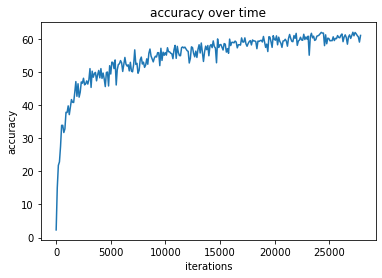

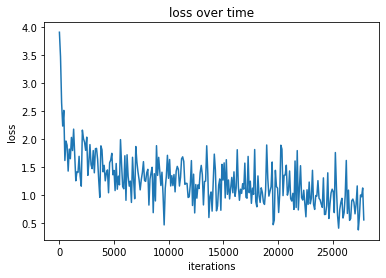

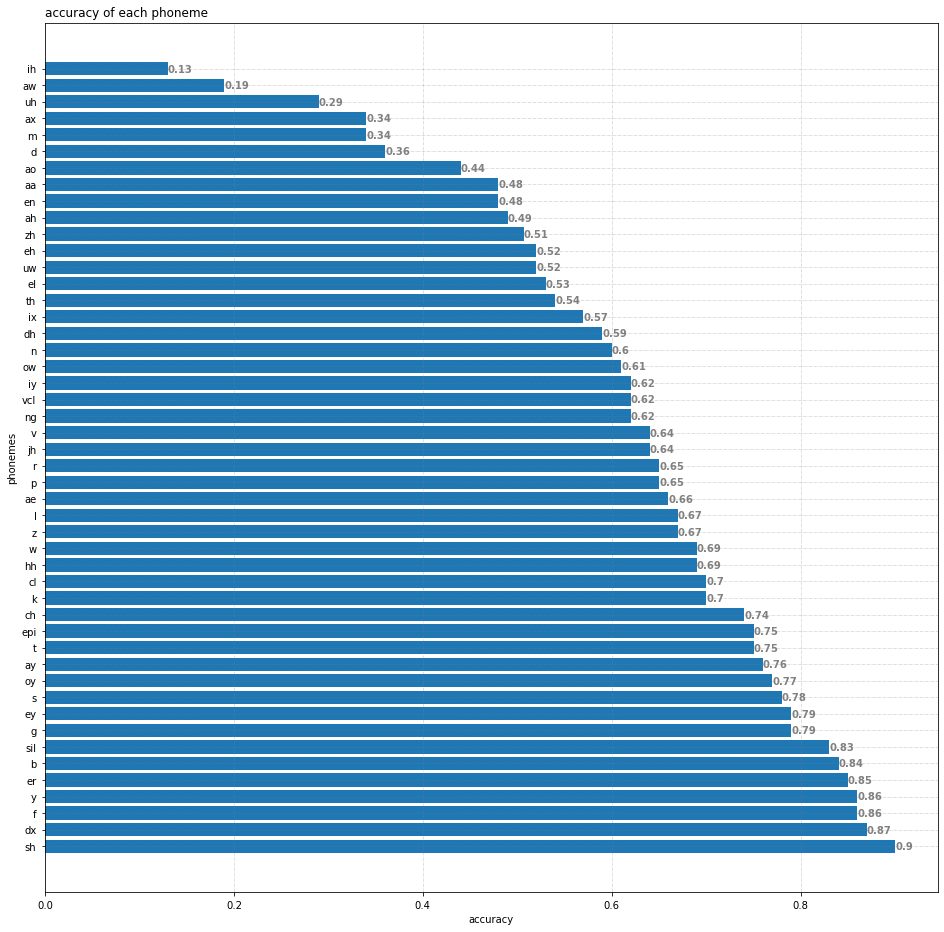

In [267]:
# 5. Train the model with stochastic gradient descent, iterating over the training dataset several times

def train_network(model, train_loader, criterion, optimizer):
    
    epochs = 10
    print ("epochs: ", epochs)

    iterations = total_examples / batch_size
    iterations = int(iterations - 1)
    print ("iterations per epoch: ", iterations)
    
    # lists for data collection
    iteration_list = []
    accuracy_list = []
    loss_list = []

    for epoch in range(epochs):
        print ("epoch: ", epoch)
        for i, (inputs, labels) in enumerate(train_loader, 0):
            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # calculate accuracy 
            if i % 100 == 0:        
                test_accuracy = test_network(model, test_loader)
                accuracy_list.append(test_accuracy)
                current_iteration = i + ((epoch) * iterations)
                iteration_list.append(current_iteration)
                loss_list.append(loss.item())
            if i % 500 == 0:
                print('\titeration: {}\t\t loss: {}\t accuracy: {}'.format(current_iteration, loss.item(), test_accuracy))
                        
    # print out stats
    print_stats(iteration_list, accuracy_list, loss_list)
    
train_network(model, train_loader, criterion, optimizer)